# Automatic program Repair (APR)


In [ ]:


import pandas as pd
import numpy as np
from data_loader.loader import load_buggy_dataset, load_data, save_data
from bug_detective.detective import process_prompt_dataset
from utils.visualization import compare_groundtruth_vs_corrected_histograms, compare_metrics_versus_bug_histograms, plot_column_distribution, plot_metrics_boxplots
from utils.simple_metrics import compute_and_store_metrics
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))


# Load buggy train dataset
buggy_train_df = load_buggy_dataset('train')

### Experiment Setup


In [ ]:
is_load_data = True

metadata = {
    'sample_size': 300,
    'instruction_prompt': "You are a helpful assistant that corrects the code based on the traceback error. You must respect the original code structure and the original code style",
    "system_prompt": "apr",
    'random_state': 23,
    'results_filename': '300_metrics_prompt_style_based.pkl',
    'temperature': 0.0,
    'max_tokens': 2500
}

In [ ]:
if is_load_data:
    prompt_data = load_data(metadata['results_filename'])
    # fix_df = prompt_data[prompt_data['response_claude-3.5-sonnet'].astype(str).str.contains('Error processing sample')].copy()
else:
    prompt_data = buggy_train_df.sample(
        n=metadata['sample_size'], random_state=metadata['random_state'])
    important_columns = ["before_merge_without_docstrings",
                         "after_merge_without_docstrings", "traceback_type", "full_traceback"]
    prompt_data = prompt_data.loc[:, [
        col for col in important_columns if col in prompt_data.columns]]
    prompt_data.head()

print(f"Sample data shape: {prompt_data.shape}")
print(f"Sample data columns: {prompt_data.columns.tolist()}")
prompt_data.head()

,before_merge_without_docstrings,after_merge_without_docstrings,traceback_type,full_traceback,response_qwen-2.5-coder-32b-instruct,response_codestral-2501,metric_qwen-2.5-coder-32b-instruct_ast_score,metric_qwen-2.5-coder-32b-instruct_text_score,metric_qwen-2.5-coder-32b-instruct_ast_score_normalized,metric_qwen-2.5-coder-32b-instruct_codebleu,...,metric_qwen-2.5-coder-32b-instruct_dataflow_match_score,metric_codestral-2501_ast_score,metric_codestral-2501_text_score,metric_codestral-2501_ast_score_normalized,metric_codestral-2501_codebleu,metric_codestral-2501_ngram_match_score,metric_codestral-2501_weighted_ngram_match_score,metric_codestral-2501_syntax_match_score,metric_codestral-2501_dataflow_match_score,response_gpt-4o
75748,"def run(self, cmd, **kwargs):\n sel...","def run(self, cmd, **kwargs):\n sel...",IndexError,An unexpected error has occurred: IndexError: ...,"def run(self, cmd, **kwargs):\n self._c...","def run(self, cmd, **kwargs):\n self._creat...",0.000000,0.752688,0.000000,0.533997,...,0.647059,0.000000,0.826667,0.000000,0.533997,0.422525,0.432303,0.600000,0.647059,"def run(self, cmd, **kwargs):\n self._creat..."
583899,"def process(self, argv=None, executable=No...","def process(self, argv=None, executable=No...",TypeError,[+] Downloading '/proc/sys/kernel/core_pattern...,"def process(self, argv=None, executable=None, ...","def process(self, argv=None, executable=None, ...",0.000000,0.997228,0.000000,0.985629,...,0.978972,0.000000,0.944957,1.000000,0.985163,0.987188,0.986527,0.983752,0.983645,"def process(self, argv=None, executable=None, ..."
532193,"def backprojection(calibrated_event_list, pixe...","def backprojection(calibrated_event_list, pixe...",TypeError,import sunpy.data\n>>> import sunpy.data.sampl...,"def backprojection(calibrated_event_list, pixe...","def backprojection(calibrated_event_list, pixe...",0.830759,0.868350,0.174448,0.666034,...,0.592105,0.831026,0.862375,0.174448,0.666034,0.549906,0.732113,0.813559,0.592105,"def backprojection(calibrated_event_list, pixe..."
357599,"def export_annotations(self,export_range,e...","def export_annotations(self,export_range,e...",AttributeError,"Traceback (most recent call last):\nFile ""main...","def export_annotations(self,export_range,expor...","def export_annotations(self, export_range, exp...",0.000000,0.995781,0.000000,0.959438,...,1.000000,0.000000,0.847722,0.000000,0.758106,0.600996,0.758020,0.895349,0.763158,"def export_annotations(self,export_range,expor..."
45974,"def summarize_corpus(corpus, ratio=0.2):\n ...","def summarize_corpus(corpus, ratio=0.2):\n ...",TypeError,----------------------------------------------...,"def summarize_corpus(corpus, ratio=0.2):\n ...","def summarize_corpus(corpus, ratio=0.2):\n ...",0.000000,0.986494,1.000000,0.983492,...,1.000000,0.000000,0.879032,0.000000,0.729199,0.788835,0.889025,0.847059,0.525000,"def summarize_corpus(corpus, ratio=0.2, INPUT_..."


In [5]:
from llm_models.open_router import create_openrouter_model, create_apr_model

qwen_model = create_openrouter_model(
    model_name="qwen/qwen-2.5-coder-32b-instruct",
    temperature=metadata['temperature'],
    max_tokens=metadata['max_tokens']
)
gpt_4o_model = create_openrouter_model(
    model_name="openai/gpt-4o",
    temperature=metadata['temperature'],
    max_tokens=metadata['max_tokens'],
)
claude_35_sonnet_model = create_openrouter_model(
    model_name="anthropic/claude-3.5-sonnet",
    temperature=metadata['temperature'],
    max_tokens=metadata['max_tokens'],
)
codestral_model = create_openrouter_model(
    model_name="mistralai/codestral-2501",
    temperature=metadata['temperature'],
    max_tokens=metadata['max_tokens'],
)

In [ ]:
outputs_qwen = await process_prompt_dataset(open_router_model=qwen_model, prompt_dataset=prompt_data, instruction_prompt=metadata['instruction_prompt'])

outputs_codestral = await process_prompt_dataset(open_router_model=codestral_model, prompt_dataset=prompt_data, instruction_prompt=metadata['instruction_prompt'])

outputs_gpt_4o = await process_prompt_dataset(open_router_model=gpt_4o_model, prompt_dataset=prompt_data, instruction_prompt=metadata['instruction_prompt'])

outputs_claude_35_sonnet = await process_prompt_dataset(
    open_router_model=claude_35_sonnet_model,
    prompt_dataset=prompt_data,
    instruction_prompt=metadata['instruction_prompt']
)

Processing sample 300/300: 100%|█████████████████████████████| 300/300 [39:36<00:00,  7.92s/samples]


In [ ]:
prompt_data['response_codestral-2501'] = outputs_codestral
prompt_data['response_qwen-2.5-coder-32b-instruct'] = outputs_qwen
prompt_data['response_gpt-4o'] = outputs_gpt_4o
prompt_data['response_claude-3.5-sonnet'] = outputs_claude_35_sonnet

Processing sample 300/300: 100%|█████████████████████████████| 300/300 [07:08<00:00,  1.43s/samples]


In [ ]:
from Bugdetectiveai.scr.utils.visualization import create_metrics_summary_table
prompt_data = compute_and_store_metrics(prompt_data)
# Create summary table for prompt metrics
response_columns_prompt = [
    col for col in prompt_data.columns if "response" in col]
summary_table_prompt = create_metrics_summary_table(
    prompt_data, response_columns_prompt)

Computing metrics for after_merge_without_docstrings vs 2 response columns...
Processing response_qwen-2.5-coder-32b-instruct...


Computing response_qwen-2.5-coder-32b-instruct: 100%|██████████| 300/300 [00:27<00:00, 10.99it/s]


  Added 8 metric columns for response_qwen-2.5-coder-32b-instruct
Processing response_codestral-2501...


Computing response_codestral-2501: 100%|██████████| 300/300 [00:23<00:00, 12.88it/s]

  Added 8 metric columns for response_codestral-2501
Completed! Added metrics for 2 response columns.
Creating metrics summary table for 2 response columns...

=== Metrics Summary Table ===
Models: 2
Metrics: 8
Statistics shown: mean ± std
Sample counts shown in parentheses

                                         ast_score             text_score   ast_score_normalized               codebleu      ngram_match_score weighted_ngram_match_score     syntax_match_score   dataflow_match_score
Qwen-2.5-Coder-32B-Instruct  0.270 ± 0.402 (n=300)  0.799 ± 0.219 (n=300)  0.315 ± 0.420 (n=300)  0.766 ± 0.184 (n=300)  0.707 ± 0.265 (n=300)      0.752 ± 0.238 (n=300)  0.798 ± 0.191 (n=300)  0.741 ± 0.263 (n=300)
Codestral-2501               0.281 ± 0.411 (n=300)  0.749 ± 0.216 (n=300)  0.284 ± 0.411 (n=300)  0.778 ± 0.185 (n=300)  0.729 ± 0.264 (n=300)      0.768 ± 0.238 (n=300)  0.808 ± 0.194 (n=300)  0.746 ± 0.265 (n=300)

Table shape: (2, 8)
Available metrics: ['ast_score', 'text_score', 'ast_sco

In [ ]:
from Bugdetectiveai.scr.utils.visualization import create_metrics_summary_table
prompt_data = compute_and_store_metrics(prompt_data)
# Create summary table for prompt metrics
response_columns_prompt = [
    col for col in prompt_data.columns if "response" in col]
summary_table_prompt = create_metrics_summary_table(
    prompt_data, response_columns_prompt)

Computing metrics for after_merge_without_docstrings vs 4 response columns...
Processing response_qwen-2.5-coder-32b-instruct...


Computing response_qwen-2.5-coder-32b-instruct: 100%|██████████| 300/300 [00:26<00:00, 11.50it/s]


  Added 8 metric columns for response_qwen-2.5-coder-32b-instruct
Processing response_codestral-2501...


Computing response_codestral-2501: 100%|██████████| 300/300 [00:24<00:00, 12.24it/s]


  Added 8 metric columns for response_codestral-2501
Processing response_gpt-4o...


Computing response_gpt-4o: 100%|██████████| 300/300 [00:33<00:00,  8.95it/s]


  Added 8 metric columns for response_gpt-4o
Processing response_claude-3.5-sonnet...


Computing response_claude-3.5-sonnet: 100%|██████████| 300/300 [00:39<00:00,  7.67it/s]

  Added 8 metric columns for response_claude-3.5-sonnet
Completed! Added metrics for 4 response columns.
Creating metrics summary table for 4 response columns...

=== Metrics Summary Table ===
Models: 4
Metrics: 8
Statistics shown: mean ± std
Sample counts shown in parentheses

                                         ast_score             text_score   ast_score_normalized               codebleu      ngram_match_score weighted_ngram_match_score     syntax_match_score   dataflow_match_score
Qwen-2.5-Coder-32B-Instruct  0.270 ± 0.402 (n=300)  0.799 ± 0.219 (n=300)  0.315 ± 0.420 (n=300)  0.766 ± 0.184 (n=300)  0.707 ± 0.265 (n=300)      0.752 ± 0.238 (n=300)  0.798 ± 0.191 (n=300)  0.741 ± 0.263 (n=300)
Codestral-2501               0.281 ± 0.411 (n=300)  0.749 ± 0.216 (n=300)  0.284 ± 0.411 (n=300)  0.778 ± 0.185 (n=300)  0.729 ± 0.264 (n=300)      0.768 ± 0.238 (n=300)  0.808 ± 0.194 (n=300)  0.746 ± 0.265 (n=300)
Gpt-4O                       0.266 ± 0.396 (n=300)  0.723 ± 0.238 (n=300)

In [ ]:
want_save_data = False
if want_save_data:
    save_data(prompt_data,metadata['results_filename'])
else:
    print("DATA NOT SAVED")

Data saved to: /Users/zanchitta/Developer/BugDetectiveAI/Bugdetectiveai/data/checkpoints/300_metrics_prompt_style_based.pkl


'/Users/zanchitta/Developer/BugDetectiveAI/Bugdetectiveai/data/checkpoints/300_metrics_prompt_style_based.pkl'

In [ ]:
import json
import os
from pathlib import Path


def save_metadata(
    metadata: dict,
    file_name: str = "metadata.json",
    data_path: str = "/Users/zanchitta/Developer/BugDetectiveAI/Bugdetectiveai/data/checkpoints/",
    override: bool = False
) -> str:
    """
    Save a metadata dictionary as a JSON file in the specified directory.

    Args:
        metadata (dict): The metadata to save.
        file_name (str): The name of the JSON file (default: "metadata.json").
        data_path (str): The directory to save the file (default: checkpoints path).
        override (bool): If True, override existing file. If False and file exists, raise an error.

    Returns:
        str: The full path to the saved JSON file.

    Raises:
        FileExistsError: If the file already exists and override is False.
    """
    # Ensure .json extension
    if not file_name.endswith(".json"):
        file_name += ".json"
    # Create directory if it doesn't exist
    Path(data_path).mkdir(parents=True, exist_ok=True)
    file_path = os.path.join(data_path, file_name)
    if os.path.exists(file_path) and not override:
        raise FileExistsError(
            f"File '{file_path}' already exists. Set override=True to overwrite.")
    with open(file_path, "w", encoding="utf-8") as f:
        json.dump(metadata, f, indent=2, ensure_ascii=False)
    return file_path


save_metadata(metadata, 'metadata_' + metadata['results_filename'])

'/Users/zanchitta/Developer/BugDetectiveAI/Bugdetectiveai/data/checkpoints/metadata_300_metrics_prompt_style_based.pkl.json'

### Save data


In [ ]:
# import pickle
# import pandas as pd
# from datetime import datetime
# from pathlib import Path
# import os

# data_path = '/Users/zanchitta/Developer/BugDetectiveAI/Bugdetectiveai/data/checkpoints'

# # Get number of rows
# num_rows = len(sample_data)

# # Get all response columns
# response_columns = [col for col in sample_data.columns if "response_" in col]
# response_names = "_".join([col.replace("response_", "") for col in response_columns])

# # Compose file name
# file_name = f"sample_data_{num_rows}_rows_{response_names}.pkl"
# file_path = os.path.join(data_path, file_name)

# Path(data_path).mkdir(parents=True, exist_ok=True)
# with open(file_path, 'wb') as f:
#     pickle.dump(sample_data, f)
# print(f"Data saved to: {file_path}")

In [19]:

from typing import Dict,List
def wilcoxon_test(
    df: pd.DataFrame,
    response_column1: str,
    response_column2: str,
    metric_name: str = "ast_score",
    reference_column: str = "after_merge_without_docstrings",
    alternative: str = "two-sided"
) -> Dict[str, float]:
    """Perform Wilcoxon signed-rank test between two response columns for a specific metric.
    
    This function compares the performance of two different response columns (e.g., different LLM models)
    using the Wilcoxon signed-rank test, which is appropriate for paired samples and doesn't assume
    normal distribution.
    
    Args:
        df (pd.DataFrame): DataFrame containing the data
        response_column1 (str): First response column name (e.g., "response_gpt4")
        response_column2 (str): Second response column name (e.g., "response_claude")
        metric_name (str): Name of the metric to compare (default: "ast_score")
        reference_column (str): Reference column used for metric calculation
        alternative (str): Alternative hypothesis: "two-sided", "greater", or "less" (default: "two-sided")
    
    Returns:
        Dict[str, float]: Dictionary containing test results:
            - statistic: Wilcoxon test statistic
            - pvalue: p-value for the test
            - mean_diff: Mean difference (col2 - col1)
            - median_diff: Median difference (col2 - col1)
            - effect_size: Effect size (Z/sqrt(N))
            - significant: Boolean indicating if p < 0.05
    
    Raises:
        ValueError: If required columns don't exist
        ImportError: If scipy is not available
    """
    try:
        from scipy import stats
    except ImportError:
        raise ImportError("scipy is required for Wilcoxon test. Install with: poetry add scipy")
    
    # Get metric column names
    clean_col1 = response_column1.replace("response_", "")
    clean_col2 = response_column2.replace("response_", "")
    
    metric_col1 = f"metric_{clean_col1}_{metric_name}"
    metric_col2 = f"metric_{clean_col2}_{metric_name}"
    
    # Validate columns exist
    missing_columns = []
    for col in [response_column1, response_column2, metric_col1, metric_col2]:
        if col not in df.columns:
            missing_columns.append(col)
    
    if missing_columns:
        raise ValueError(f"Missing columns: {missing_columns}")
    
    # Extract metric values, filtering out NaN values
    values1 = df[metric_col1].dropna()
    values2 = df[metric_col2].dropna()
    
    # Ensure we have the same indices for paired comparison
    common_idx = values1.index.intersection(values2.index)
    if len(common_idx) < 3:
        raise ValueError(f"Insufficient paired data: only {len(common_idx)} valid pairs found")
    
    paired_values1 = values1.loc[common_idx]
    paired_values2 = values2.loc[common_idx]
    
    # Perform Wilcoxon test
    statistic, pvalue = stats.wilcoxon(
        paired_values1, 
        paired_values2, 
        alternative=alternative
    )
    
    # Calculate descriptive statistics
    differences = paired_values2 - paired_values1
    mean_diff = differences.mean()
    median_diff = differences.median()
    
    # Calculate effect size (Z/sqrt(N))
    n = len(common_idx)
    effect_size = abs(statistic) / (n * (n + 1) / 2) ** 0.5
    
    # Determine significance
    significant = pvalue < 0.05
    
    return {
        "statistic": statistic,
        "pvalue": pvalue,
        "mean_diff": mean_diff,
        "median_diff": median_diff,
        "effect_size": effect_size,
        "significant": significant,
        "n_pairs": n,
        "alternative": alternative
    }


def compare_multiple_responses(
    df: pd.DataFrame,
    response_columns: List[str],
    metric_name: str = "ast_score",
    reference_column: str = "after_merge_without_docstrings",
    alpha: float = 0.05
) -> pd.DataFrame:
    """Compare multiple response columns using pairwise Wilcoxon tests.
    
    This function performs pairwise comparisons between all response columns for a given metric,
    creating a comprehensive comparison matrix.
    
    Args:
        df (pd.DataFrame): DataFrame containing the data
        response_columns (List[str]): List of response column names to compare
        metric_name (str): Name of the metric to compare (default: "ast_score")
        reference_column (str): Reference column used for metric calculation
        alpha (float): Significance level (default: 0.05)
    
    Returns:
        pd.DataFrame: DataFrame with pairwise comparison results
    """
    results = []
    
    for i, col1 in enumerate(response_columns):
        for j, col2 in enumerate(response_columns):
            if i >= j:  # Skip self-comparisons and duplicate pairs
                continue
                
            try:
                test_result = wilcoxon_test(
                    df, col1, col2, metric_name, reference_column
                )
                
                results.append({
                    "response_1": col1,
                    "response_2": col2,
                    "metric": metric_name,
                    "statistic": test_result["statistic"],
                    "pvalue": test_result["pvalue"],
                    "mean_diff": test_result["mean_diff"],
                    "median_diff": test_result["median_diff"],
                    "effect_size": test_result["effect_size"],
                    "significant": test_result["significant"],
                    "n_pairs": test_result["n_pairs"]
                })
                
            except Exception as e:
                print(f"Error comparing {col1} vs {col2}: {e}")
                continue
    
    if not results:
        return pd.DataFrame()
    
    return pd.DataFrame(results)


def print_wilcoxon_summary(
    df: pd.DataFrame,
    response_columns: List[str],
    metric_name: str = "ast_score",
    reference_column: str = "after_merge_without_docstrings"
):
    """Print a formatted summary of Wilcoxon test results.
    
    Args:
        df (pd.DataFrame): DataFrame containing the data
        response_columns (List[str]): List of response column names to compare
        metric_name (str): Name of the metric to compare
        reference_column (str): Reference column used for metric calculation
    """
    print(f"\n{'='*60}")
    print(f"WILCOXON TEST SUMMARY")
    print(f"{'='*60}")
    print(f"Metric: {metric_name}")
    print(f"Reference: {reference_column}")
    print(f"Response columns: {len(response_columns)}")
    print(f"{'='*60}")
    
    # Perform pairwise comparisons
    comparison_df = compare_multiple_responses(
        df, response_columns, metric_name, reference_column
    )
    
    if comparison_df.empty:
        print("No valid comparisons found.")
        return
    
    # Print results
    for _, row in comparison_df.iterrows():
        print(f"\n{row['response_1']} vs {row['response_2']}")
        print(f"  Statistic: {row['statistic']:.4f}")
        print(f"  p-value: {row['pvalue']:.6f}")
        print(f"  Mean diff (col2-col1): {row['mean_diff']:.6f}")
        print(f"  Median diff (col2-col1): {row['median_diff']:.6f}")
        print(f"  Effect size: {row['effect_size']:.4f}")
        print(f"  Significant (α=0.05): {'Yes' if row['significant'] else 'No'}")
        print(f"  N pairs: {row['n_pairs']}")
    
    # Summary statistics
    significant_comparisons = comparison_df[comparison_df['significant']].shape[0]
    total_comparisons = comparison_df.shape[0]
    
    print(f"\n{'='*60}")
    print(f"SUMMARY STATISTICS")
    print(f"{'='*60}")
    print(f"Total comparisons: {total_comparisons}")
    print(f"Significant differences: {significant_comparisons}")
    print(f"Significance rate: {significant_comparisons/total_comparisons*100:.1f}%")
    
    # Effect size interpretation
    small_effects = comparison_df[comparison_df['effect_size'] < 0.1].shape[0]
    medium_effects = comparison_df[(comparison_df['effect_size'] >= 0.1) & (comparison_df['effect_size'] < 0.3)].shape[0]
    large_effects = comparison_df[comparison_df['effect_size'] >= 0.3].shape[0]
    
    print(f"\nEffect sizes:")
    print(f"  Small (<0.1): {small_effects}")
    print(f"  Medium (0.1-0.3): {medium_effects}")
    print(f"  Large (≥0.3): {large_effects}")


In [25]:
from itertools import combinations
response_cols = [col for col in prompt_data.columns if col.startswith("response_")]
# results = []
# for col1, col2 in combinations(response_cols, 2):
#     res = wilcoxon_test(prompt_data, col1, col2, "ast_score")
#     results.append({
#         "response_1": col1,
#         "response_2": col2,
#         **res
#     })

# Compare multiple models
comparison_df = compare_multiple_responses(prompt_data, response_cols,metric_name='codebleu')

# Print formatted summary
# print_wilcoxon_summary(prompt_data,response_cols[0:1], "codebleu")

comparison_df.head(30)

,response_1,response_2,metric,statistic,pvalue,mean_diff,median_diff,effect_size,significant,n_pairs
0,response_qwen-2.5-coder-32b-instruct,response_codestral-2501,codebleu,4409.0,1.505793e-07,0.011576,0.000000,20.749671,True,300
1,response_qwen-2.5-coder-32b-instruct,response_gpt-4o,codebleu,12098.0,6.051725e-01,-0.018901,0.000000,56.935705,False,300
2,response_qwen-2.5-coder-32b-instruct,response_claude-3.5-sonnet,codebleu,9431.0,3.414794e-10,-0.036644,-0.012781,44.384248,True,300
3,response_codestral-2501,response_gpt-4o,codebleu,6444.0,2.299582e-07,-0.030477,0.000000,30.326805,True,300
4,response_codestral-2501,response_claude-3.5-sonnet,codebleu,6129.0,4.342098e-19,-0.048221,-0.021024,28.844349,True,300
5,response_gpt-4o,response_claude-3.5-sonnet,codebleu,11099.0,2.652285e-07,-0.017744,-0.007506,52.234203,True,300


In [21]:
results[0]

{'response_1': 'response_qwen-2.5-coder-32b-instruct',
 'response_2': 'response_codestral-2501',
 'statistic': 504.0,
 'pvalue': 0.004030319823957632,
 'mean_diff': 0.010975086451496226,
 'median_diff': 0.0,
 'effect_size': 2.371928858888459,
 'significant': True,
 'n_pairs': 300,
 'alternative': 'two-sided'}

Creating boxplots using stored metrics for 4 response columns...


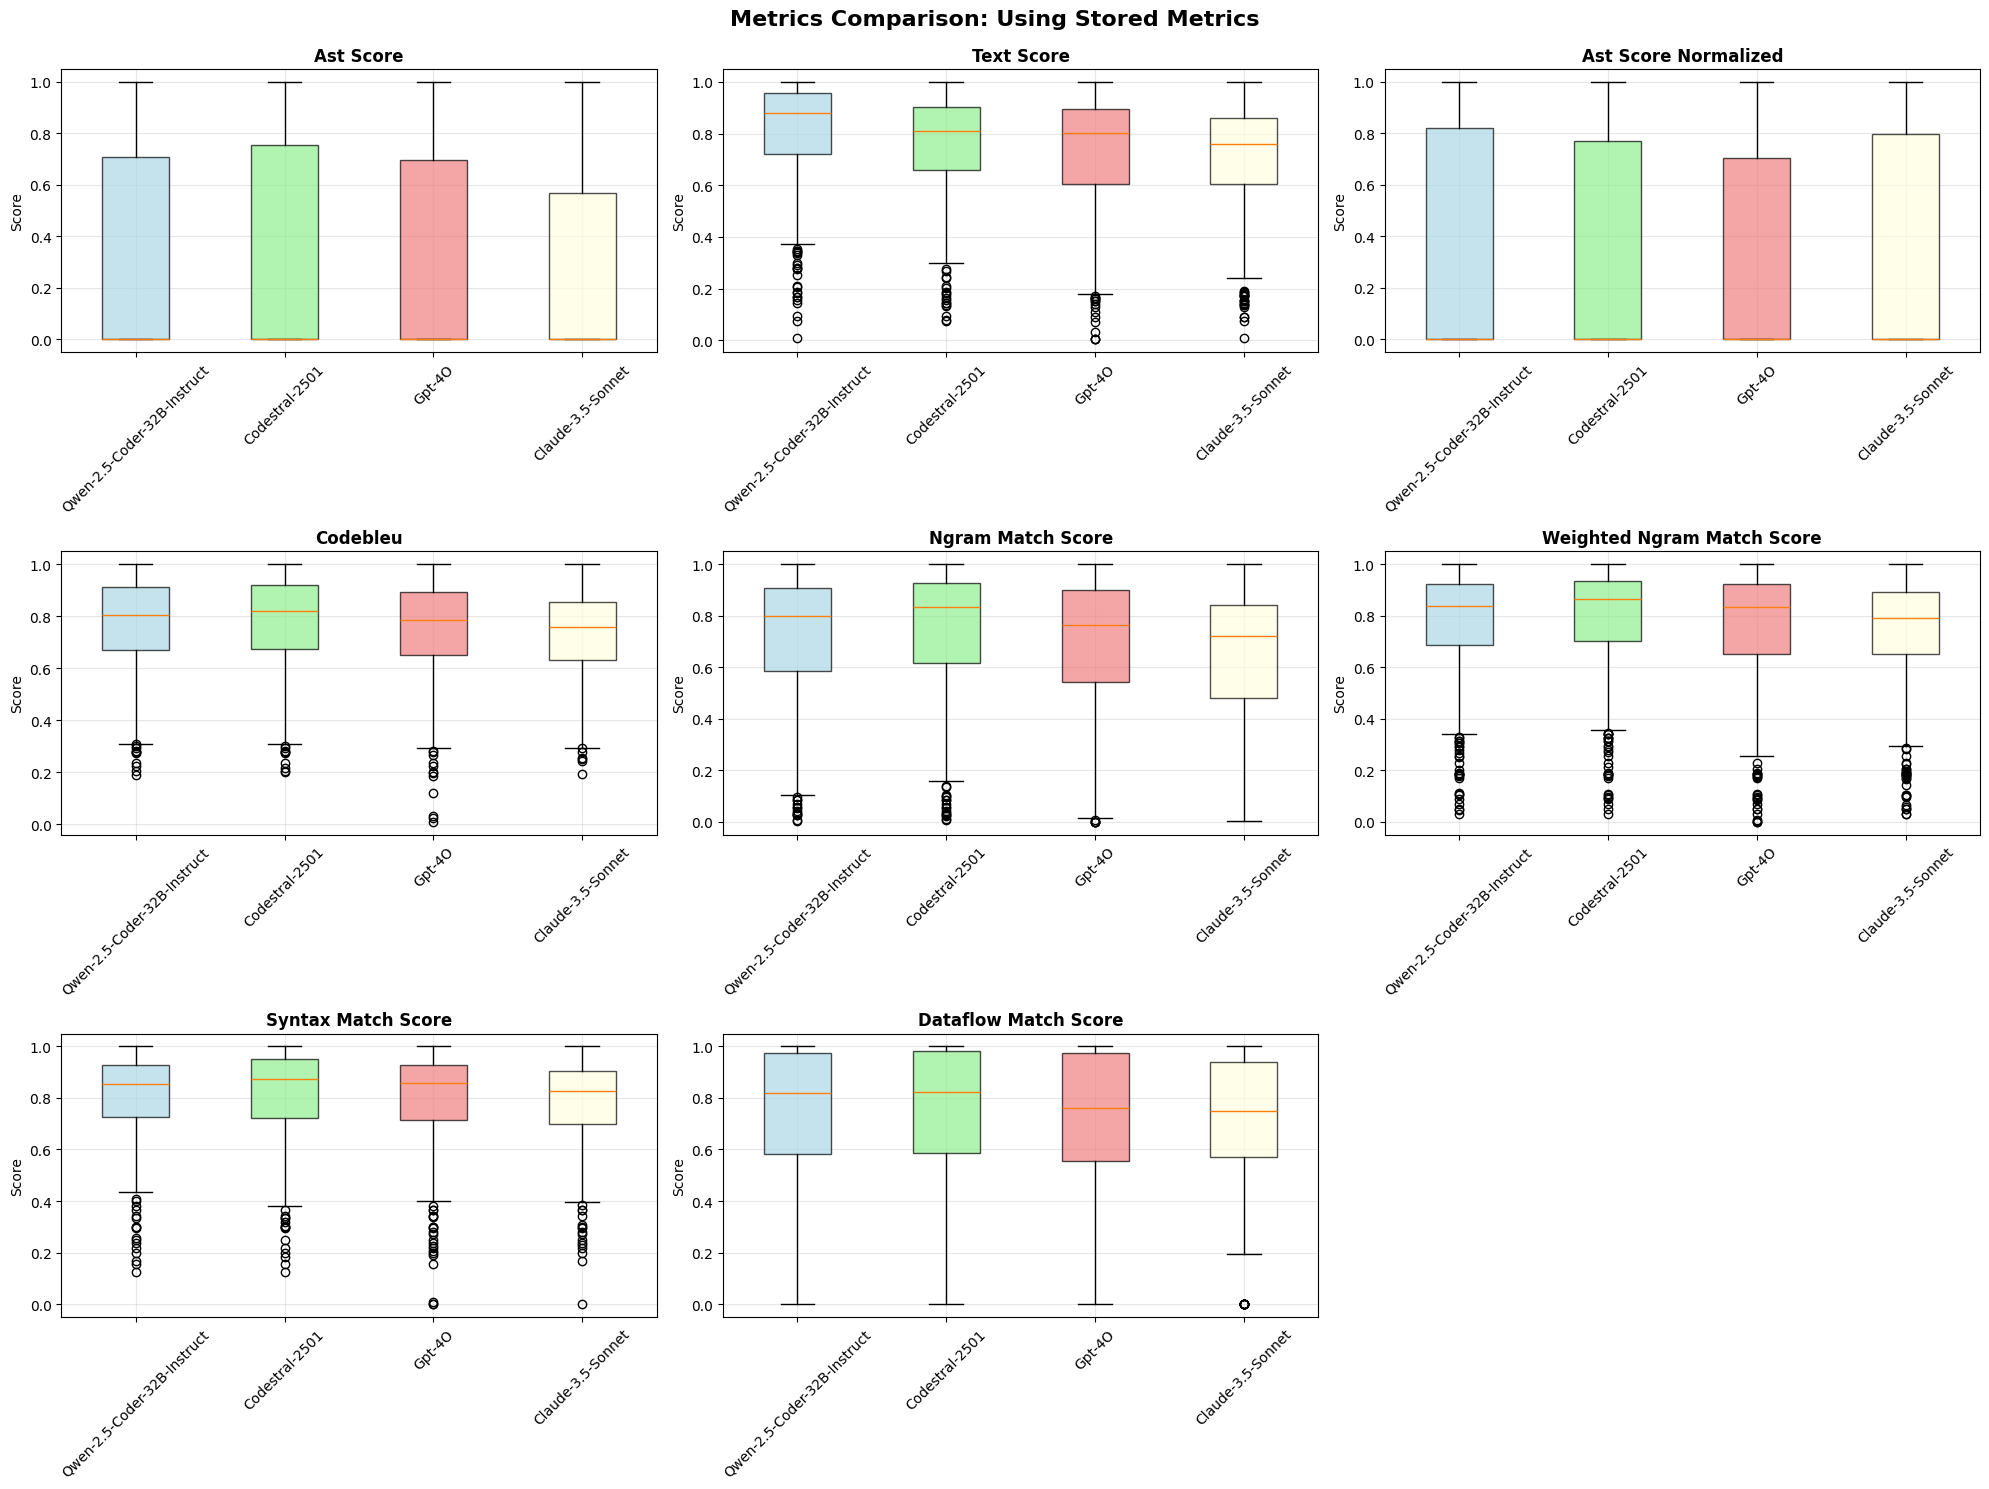


=== SUMMARY STATISTICS (FROM STORED METRICS) ===
Number of response columns: 4
Number of metrics: 8
Available metrics: ['ast_score', 'text_score', 'ast_score_normalized', 'codebleu', 'ngram_match_score', 'weighted_ngram_match_score', 'syntax_match_score', 'dataflow_match_score']

Ast Score:
  Qwen-2.5-Coder-32B-Instruct: mean=0.270, std=0.402, median=0.000 (n=300)
  Codestral-2501: mean=0.281, std=0.411, median=0.000 (n=300)
  Gpt-4O: mean=0.266, std=0.396, median=0.000 (n=300)
  Claude-3.5-Sonnet: mean=0.234, std=0.369, median=0.000 (n=300)

Text Score:
  Qwen-2.5-Coder-32B-Instruct: mean=0.799, std=0.219, median=0.878 (n=300)
  Codestral-2501: mean=0.749, std=0.216, median=0.809 (n=300)
  Gpt-4O: mean=0.723, std=0.238, median=0.802 (n=300)
  Claude-3.5-Sonnet: mean=0.693, std=0.227, median=0.759 (n=300)

Ast Score Normalized:
  Qwen-2.5-Coder-32B-Instruct: mean=0.315, std=0.420, median=0.000 (n=300)
  Codestral-2501: mean=0.284, std=0.411, median=0.000 (n=300)
  Gpt-4O: mean=0.270, 

In [12]:

plot_metrics_boxplots(
    prompt_data, reference_column="after_merge_without_docstrings")

In [ ]:

plot_metrics_boxplots(
    prompt_data, reference_column="after_merge_without_docstrings")

In [ ]:
plot_metrics_boxplots(
    sample_data, reference_column="after_merge_without_docstrings")

### Syntax Match Score:

prompt = ""You are a helpful assistant that corrects the code based on the traceback error. You must respect the original code structure and the original code style""

No prompt = ""You are a helpful assistant that corrects the code based on the traceback error.""

#### Prompt

- Qwen-2.5-Coder-32B-Instruct: mean=0.783, std=0.182, median=0.816 (n=100)
- Gpt-4O-Mini: mean=0.784, std=0.186, median=0.840 (n=100)
- Gemini-2.5-Flash: mean=0.775, std=0.193, median=0.821 (n=100)
- Codestral-2501: mean=0.814, std=0.176, median=0.856 (n=100)

#### No prompt

- Qwen-2.5-Coder-32B-Instruct: mean=0.796, std=0.188, median=0.838 (n=100)
- Gpt-4O-Mini: mean=0.741, std=0.229, median=0.804 (n=100)
- Gemini-2.0-Flash-001: mean=0.766, std=0.172, median=0.804 (n=100)
- Gemini-2.5-Flash: mean=0.757, std=0.191, median=0.805 (n=100)
- Codestral-2501: mean=0.804, std=0.190, median=0.854 (n=100)
- Gpt-4.1: mean=0.735, std=0.184, median=0.781 (n=100)

### CodeBleu

#### Prompt

- Qwen-2.5-Coder-32B-Instruct: mean=0.757, std=0.181, median=0.797 (n=100)
- Gpt-4O-Mini: mean=0.744, std=0.181, median=0.782 (n=100)
- Gemini-2.5-Flash: mean=0.728, std=0.198, median=0.768 (n=100)
- Codestral-2501: mean=0.776, std=0.184, median=0.817 (n=100)

#### No prompt

- Qwen-2.5-Coder-32B-Instruct: mean=0.756, std=0.181, median=0.786 (n=100)
- Gpt-4O-Mini: mean=0.703, std=0.225, median=0.761 (n=100)
- Gemini-2.0-Flash-001: mean=0.716, std=0.172, median=0.732 (n=100)
- Gemini-2.5-Flash: mean=0.678, std=0.187, median=0.698 (n=100)
- Codestral-2501: mean=0.771, std=0.187, median=0.822 (n=100)
- Gpt-4.1: mean=0.661, std=0.196, median=0.688 (n=100)


In [ ]:
compare_metrics_versus_bug_histograms(
    sample_data['before_merge'], sample_data['after_merge'], p['response_gpt-4o-mini'])

In [ ]:
compare_groundtruth_vs_corrected_histograms(
    sample_data['after_merge_without_docstrings'], sample_data['response_qwen-2.5-coder-32b-instruct'])

#### qwen

Exact Match - Groundtruth vs Corrected: mean=0.010, std=0.099
Ast Score - Groundtruth vs Corrected: mean=0.201, std=0.346
Text Score - Groundtruth vs Corrected: mean=0.734, std=0.208
Ast Score Normalized - Groundtruth vs Corrected: mean=0.237, std=0.382
Codebleu - Groundtruth vs Corrected: mean=0.733, std=0.197
Ngram Match Score - Groundtruth vs Corrected: mean=0.644, std=0.298
Weighted Ngram Match Score - Groundtruth vs Corrected: mean=0.706, std=0.258
Syntax Match Score - Groundtruth vs Corrected: mean=0.783, std=0.189
Dataflow Match Score - Groundtruth vs Corrected: mean=0.739, std=0.257

#### gpt

Exact Match - Groundtruth vs Corrected: mean=0.000, std=0.000
Ast Score - Groundtruth vs Corrected: mean=0.200, std=0.347
Text Score - Groundtruth vs Corrected: mean=0.652, std=0.274
Ast Score Normalized - Groundtruth vs Corrected: mean=0.253, std=0.390
Codebleu - Groundtruth vs Corrected: mean=0.662, std=0.226
Ngram Match Score - Groundtruth vs Corrected: mean=0.547, std=0.322
Weighted Ngram Match Score - Groundtruth vs Corrected: mean=0.623, std=0.308
Syntax Match Score - Groundtruth vs Corrected: mean=0.740, std=0.230
Dataflow Match Score - Groundtruth vs Corrected: mean=0.660, std=0.290

Boxplot pra cada modelo vs gt lado a lado
adicionar modelos de tamanho similares.

sera que se eu pedir (mudança de prompt) para ele fixar o estilo ele perde a corretude no bug

add mais 2 modelos (pequeno e medio)


In [ ]:
compare_groundtruth_vs_corrected_histograms(
    sample_data['after_merge_without_docstrings'], sample_data['response_gpt-4o-mini'])

In [ ]:
compare_groundtruth_vs_corrected_histograms(sample_data[sample_data['traceback_type'] == 'AttributeError']
                                            ['after_merge'], sample_data[sample_data['traceback_type'] == 'AttributeError']['response_gpt-4o-mini'])

In [ ]:
compare_groundtruth_vs_corrected_histograms(sample_data[sample_data['traceback_type'] == 'ValueError']
                                            ['after_merge'], sample_data[sample_data['traceback_type'] == 'ValueError']['response_gpt-4o-mini'])

In [ ]:
# Call the function with the lists
compare_metrics_versus_bug_histograms(
    prompt_data['before_merge_without_docstrings'], prompt_data['after_merge_without_docstrings'], prompt_data['response_qwen-2.5-coder-32b-instruct'])

In [ ]:
from utils.simple_metrics import codebleu
codebleu_scores = codebleu(
    sample_data['before_merge'].iloc[0], sample_data['after_merge'].iloc[0])
print(codebleu_scores)

In [ ]:
codebleu_scores = codebleu(sample_data['before_merge_without_docstrings'].iloc[0],
                           sample_data['after_merge_without_docstrings'].iloc[0])
print(codebleu_scores)

In [ ]:
print(prompt_data['after_merge_without_docstrings'].iloc[0])

In [ ]:
print(prompt_data['response_gpt-4o'].iloc[0])